# Multilayer perceptron

In this section, I will develop a neural network that will take in previous words' embedding vector as input, concatenate these vectors into one long vector, and feed the resulting vector into subsequent neural network.

In [1]:
from my_utils import names, chars, c2i, i2c
import torch

In [2]:
n = 3  # N as in N-gram

def sliding_window(name: str):
    """
        This function constructs model's inputs
    """
    context = [c2i['<s>']] * n
    Xs, Ys = [], []
    for y in list(name) + ['<e>']:
        Xs.append(context)
        Ys.append(c2i[y])
        context = context[1:]+[c2i[y]]

    return Xs, Ys

In [3]:
sliding_window(name='juhani')

([[0, 0, 0],
  [0, 0, 27],
  [0, 27, 26],
  [27, 26, 4],
  [26, 4, 45],
  [4, 45, 1],
  [45, 1, 30]],
 [27, 26, 4, 45, 1, 30, 46])

### Train-val-test split

In [9]:
import random

Xs, Ys = [], []
for name in names:
    x, y = sliding_window(name=name)
    Xs.extend(x)
    Ys.extend(y)

indices = list(range(len(Xs)))
train_idx = indices[int(len(indices)*0.8)]
val_idx = indices[int(len(indices)*0.9)]

random.shuffle(indices)
Xs = torch.tensor(Xs)
Ys = torch.tensor(Ys)
X_train, Y_train = Xs[indices[:train_idx]], Ys[indices[:train_idx]]
X_val, Y_val = Xs[indices[train_idx:val_idx]], Ys[indices[train_idx:val_idx]]
X_test, Y_test = Xs[indices[val_idx:]], Ys[indices[val_idx:]]

print(f'{X_train.shape=},\n{Y_train.shape=}\n')
print(f'{X_val.shape=},\n{Y_val.shape=}\n')
print(f'{X_test.shape=},\n{Y_test.shape=}\n')

X_train.shape=torch.Size([39267, 3]),
Y_train.shape=torch.Size([39267])

X_val.shape=torch.Size([4908, 3]),
Y_val.shape=torch.Size([4908])

X_test.shape=torch.Size([4909, 3]),
Y_test.shape=torch.Size([4909])



### Test run Forward-Backward

In [13]:
"""
    Word representation method: word embedding
    We first one-hot encode a word. Then, use one-hot vector
    to pluck out an embedding vector from the Embedding matrix.
    Alternatively, we can simply use word index to grapse 
    its corresponding embedding vector as well. Here we'll use
    the former approach. (Both are 100% the same functionality,
    but I guess using word indexing is faster as it requires no
    matrix multiplication)
"""
import torch.nn.functional as F
Xenc = F.one_hot(X_train, num_classes=len(c2i)).float()

Xenc.shape
# (..., word_len, one_hot)

torch.Size([39267, 3, 47])

In [12]:
Xenc_sample = Xenc[:5,:,:]
Ys_sample = Y_train[:5]

# Define layers
E = torch.randn(size=(47, 64), requires_grad=True)  # Embedding lookup matrix
W1 = torch.randn(size=(64*n, 64), requires_grad=True) # Hidden layer
O = torch.randn(size=(64, len(c2i)), requires_grad=True) # Output layer

# Forward pass
o1 = (Xenc_sample @ E).view(len(Xenc_sample), -1)
o2 = (o1 @ W1).tanh()
o3 = (o2 @ O).exp()
o3_denom = o3.sum(dim=-1, keepdim=True)
output = o3 / o3_denom

# Loss function: Negative Log-likehood
loss = -1 * output[ torch.arange(len(o3)) , Ys_sample].log()
reduced_loss = loss.mean()

reduced_loss.backward()

### Fully training

In [19]:
# Define layers
E = torch.randn((47, 128), requires_grad=True)  # Embedding lookup matrix
W1 = torch.randn((128*n, 64), requires_grad=True) # Hidden layer 1
b1 = torch.randn(64, requires_grad=True) # Bias for layer 1
O = torch.randn((64, len(c2i)), requires_grad=True) # Output layer
b2 = torch.randn(len(c2i), requires_grad=True) # Bias for output layer

parameters = [E, W1, b1, O, b2]
total_loss = 0.0
train_losses, val_losses = [], []

In [20]:
# Matrix multiplying one-hot with the embedding is equivalent to looking up.
(Xenc[0,0] @ E) == E[Xs[0,0]]

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True])

In [21]:
Xenc_train = F.one_hot(X_train, num_classes=len(c2i)).float()
Xenc_val = F.one_hot(X_val, num_classes=len(c2i)).float()
Xenc_test = F.one_hot(X_test, num_classes=len(c2i)).float()

In [22]:
for i in range(1000):

    # Forward pass
    o1 = (Xenc_train @ E).view(len(Xenc_train), -1)
    o2 = (o1 @ W1 + b1).tanh()
    logits = o2 @ O + b2
    train_loss = F.cross_entropy(logits, Y_train)
    total_loss += train_loss

    # Refresh gradient of all parameters
    for parameter in parameters:
        parameter.grad = None
        
    # Backward pass
    train_loss.backward()

    # Update parameters
    lr = 1.0 if i < 300 else 0.1
    for parameter in parameters:
        parameter.data += -lr * parameter.grad

    # Evaluation on val set
    if i % 100 == 0:
        o1 = (Xenc_val @ E).view(len(Xenc_val), -1)
        o2 = (o1 @ W1 + b1).tanh()
        val_logits = o2 @ O + b2
        val_loss = F.cross_entropy(val_logits, Y_val)
        print(f'Train loss: {train_loss.item():.3f}\tVal loss: {val_loss.item():.3f}')
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

Train loss: 18.417	Val loss: 15.9
Train loss: 3.575	Val loss: 3.72
Train loss: 2.854	Val loss: 3.04
Train loss: 2.576	Val loss: 2.74
Train loss: 2.543	Val loss: 2.71
Train loss: 2.526	Val loss: 2.69
Train loss: 2.510	Val loss: 2.68
Train loss: 2.496	Val loss: 2.66
Train loss: 2.482	Val loss: 2.65
Train loss: 2.469	Val loss: 2.64


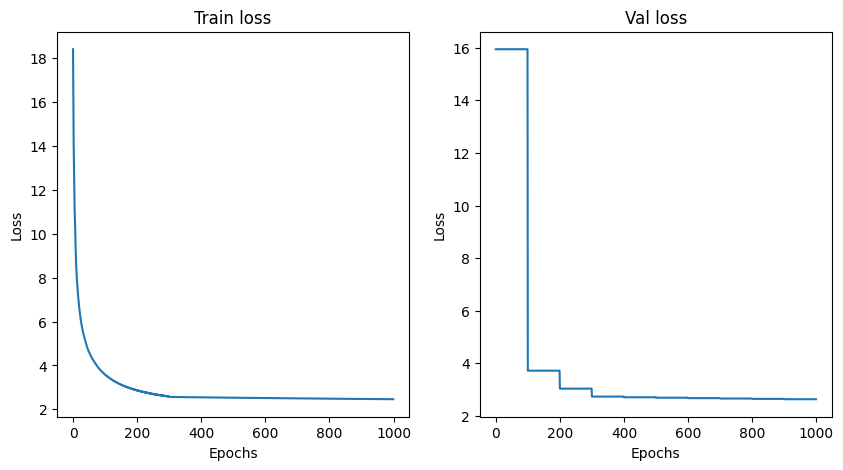

In [26]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(list(range(len(train_losses))), train_losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Train loss')

ax[1].plot(list(range(len(val_losses))), val_losses)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title('Val loss')

plt.show()

### Try generating

In [27]:
for _ in range(5):
    tokens = [c2i['<s>']] * n

    while True:
        recent_token = torch.tensor([tokens[-n:]])
        input_vector = F.one_hot(recent_token, num_classes=len(c2i)).float()

        o1 = (input_vector @ E).view(len(input_vector), -1)
        o2 = (o1 @ W1 + b1).tanh()
        logits_output = o2 @ O + b2
        counts_output = logits_output.exp()
        probs_output = counts_output / counts_output.sum(1, keepdims=True)

        next_idx = torch.multinomial(probs_output, num_samples = 1).item()
        tokens.append(next_idx)
        
        if i2c[next_idx] == '<e>':
            break

    print(''.join([i2c[i] for i in tokens][3:-1]))

laserjene
oamani
gccab
muthi-ker
sis
